In [1]:
import ast
import pandas as pd
import numpy as np
import os
from time import ctime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=300
%matplotlib inline

In [2]:
%%time
fl=pd.read_csv('./prepared_train_27Dec.csv', chunksize=10000, low_memory=False)
data = pd.concat([i for i in fl], ignore_index=True)
data['user_id'] = data['userId'].astype(int)
print data.shape

label = pd.read_csv('./Training_set.csv')
print label.shape

df = data.set_index('user_id').join(label.set_index('user_id'), how='inner', lsuffix='data_')
print df.shape

(195186, 93)
(108011, 3)
(102514, 94)
CPU times: user 7.25 s, sys: 809 ms, total: 8.06 s
Wall time: 10.8 s


In [ ]:
# df.head(1).transpose()

In [4]:
df['skills'].head()

user_id
1018449    [{u'usages': 0, u'seo_url': u'php', u'islocal'...
8288991    [{u'usages': 37, u'seo_url': u'rendering', u'i...
314218                                                    []
1240449    [{u'usages': 0, u'seo_url': u'php', u'islocal'...
2157025    [{u'usages': 0, u'seo_url': u'windows', u'islo...
Name: skills, dtype: object

In [5]:
skills = []
seo = []
def helper(x):
    name, url = [], []
    global skills, seo
    try:
        content = ast.literal_eval(x)
        for i in content:           
            name.append(i['name'])            
            url.append(i['seo_url'])
    except:
        return False
    
    skills.append(name)
    seo.append(url)
    return True

In [6]:
%%time
df['retrieve_skillName'] = df['skills'].apply(helper)

CPU times: user 37.3 s, sys: 115 ms, total: 37.5 s
Wall time: 37.4 s


In [7]:
len(skills), len(seo), df.shape

(102514, 102514, (102514, 95))

In [8]:
%%time
import itertools
u_skills = list(itertools.chain.from_iterable(skills))
u_seo = list(itertools.chain.from_iterable(seo))
print len(u_skills), len(u_seo)

1174590 1174590
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 79.6 ms


In [9]:
initial = pd.DataFrame(columns=list(set(u_skills)))
initial.shape

(0, 1040)

In [11]:
%%time
from time import time
collect, n, s = [], 0, time()
for i in skills:
    n+=1
    if n%10000==0: 
        print n/10000, '{:.2f}s  '.format(time()-s),
        s=time()
    collect.append(initial.append(dict.fromkeys(i,1), ignore_index=True))
df_s = pd.concat(collect)
print df_s.shape

1 22.74s   2 22.85s   3 22.91s   4 22.64s   5 22.93s   6 22.98s   7 22.65s   8 22.61s   9 23.06s   10 22.64s  

KeyboardInterrupt: 

In [ ]:
df_s.shape, df.shape

In [ ]:
df_s.head()

In [ ]:
df_skills = pd.concat([df[[]].reset_index(), df_s.reset_index(drop=True)], axis=1)
df_skills = df_skills.set_index('user_id')
df_skills.shape

In [ ]:
# df_skills.to_csv('skills.golden.train.csv')

### start from here

In [ ]:
import ast
import pandas as pd
import numpy as np
import os
from time import ctime
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=300
%matplotlib inline

In [ ]:
%%time
df_skills = pd.read_csv('./skills.golden.train.csv')
df_skills = df_skills.set_index('user_id')
print df_skills.shape

In [ ]:
df_skills = df_skills.fillna(0)
df_skills = df_skills.astype(int)

In [ ]:
# sns.distplot?

In [ ]:
plt.figure(figsize=(20,6))
ax = sns.distplot(df_skills.sum(), bins=1000, kde=False)
plt.ylim(0, None)
plt.xlim(0, 5000)
# ax.xaxis.set_ticks(np.arange(0, 501, 10))
ax.xaxis.set_tick_params(labelsize=9, rotation=-45)

In [ ]:
(df_skills.sum()==1).sum()

In [ ]:
df_skills.sum().hist(bins=50, range=[0, 500], lw=1)

In [ ]:
df_skills.sum().hist(bins=50, range=[0, 5000])

In [ ]:
df_skills.sum().hist(bins=50)

In [ ]:
(df_skills.sum()<=10).sum()

In [ ]:
df_skills.sum().max()

http://www.informit.com/articles/article.aspx?p=2756471&seqNum=4

In [ ]:
df_skills.sum().describe()

In [ ]:
(df_skills.sum()<100).sum()

In [ ]:
(df_skills.sum()<10).sum()

In [ ]:
df_skills.sum()[(df_skills.sum()<10)].index

In [ ]:
delete_10 = df_skills.sum()[(df_skills.sum()<10)].index
len(delete_10)

In [ ]:
df_skills_V1 = df_skills.drop(delete_10, axis=1)
df_skills_V1.shape

In [ ]:
df_skills_V1_pre = df[['label']].join(df_skills_V1, how='inner')
df_skills_V1_pre.shape

In [ ]:
df_skills_V1_pre.head()

### model

In [ ]:
from parseHelper import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

In [ ]:
y=df_skills_V1_pre.pop('label')

from sklearn.model_selection import train_test_split
dim=lambda *x: [i.shape for i in x]
X_train, X_test, y_train, y_test = train_test_split(df_skills_V1_pre, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

In [ ]:
%%time
fr=RandomForestClassifier(n_jobs=36, n_estimators=200, min_samples_split=3)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

In [ ]:
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

___

In [ ]:
import xgboost as xgb

In [ ]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.9,
#     'eta': 0.1,
    'colsample_bytree': 0.9,
    'max_depth': 18,
    'subsample': 0.9,
#     'alpha': 0.2,
#     'lambda':0.8,
#     'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':36
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [ ]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=300, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

In [ ]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [41]:
stat = pd.read_csv('desc_stat.csv')
print stat.shape
stat.head()

(903, 2)


,user_id,desc_stat
0,13767750,M
1,699835,M
2,1036584,M
3,554028,M
4,789240,M


In [42]:
X_test.shape

(30755, 887)

In [43]:
desc = X_test[[]].join(stat.set_index('user_id'))['desc_stat'].values
print desc.shape
desc

(30755,)


array([nan, nan, nan, ..., nan, nan, nan], dtype=object)

In [46]:
prediction = clf.predict(d_test)>.5

In [47]:
final = (pd.Series(desc).fillna('')+pd.Series(prediction).map({1:'M',0:'F'}))\
.str.replace('MM','M').str.replace('FM','F').str.replace('FF','F').str.replace('MF','M')
final.value_counts()

M    29704
F     1051
dtype: int64

In [48]:
prediction

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

accuracy 0.838497805235
statistic
M    29704
F     1051
dtype: int64
Confusion matrix, without normalization
[[  668  4584]
 [  383 25120]]


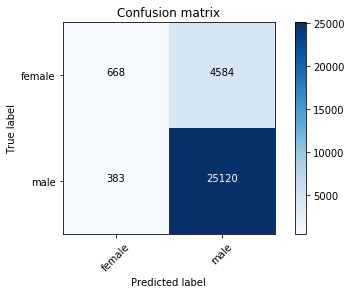

In [49]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), final.map({'M':1,'F':0}))
print 'statistic'
print final.value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),final.map({'M':1,'F':0})), ['female','male'])

#### compare

accuracy 0.838627865388
statistic
male      29708
female     1047
dtype: int64
Confusion matrix, without normalization
[[  668  4584]
 [  379 25124]]


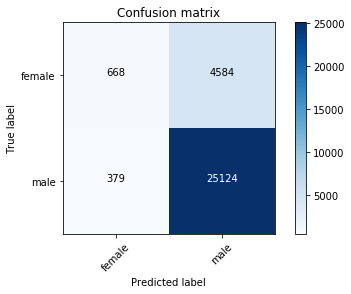

In [95]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [47]:
(clf.predict(d_test)>.5).shape

(30755,)

In [48]:
X_test.shape

(30755, 887)

In [49]:
df.shape

(102514, 94)

In [44]:
df = df.drop(['retrieve_skillName'], axis=1)

In [45]:
%%time
df.to_csv('info.label.train.csv')

CPU times: user 5.86 s, sys: 90 ms, total: 5.95 s
Wall time: 5.96 s
